In [170]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from IPython.display import display, HTML
import emcee
import corner
display(HTML("<style>.container { width:100% !important; }</style>"))

In [189]:
def make_velocity_sample(a1, a2, f, N, verbose=True):
    """Make a NS kick velocity distribution using two Maxwellian components and their relative contribution.
    
    a1 = the scale parameter of the ECSN kick velocity distribution
    a2 = the scale parameter of the CCSN kick velocity distribution
     f = the fraction of NSs formed by ECSN
     N = the sample size
     verbose: if True, report on the sample.
     
    """
    N_ECSN = st.binom(N, f_true).rvs()
    if verbose:
        print(f"True number of ECSN: {N_ECSN}")
        print(f"True number of CCSN: {N - N_ECSN}")

    # the two kick velocity distributions
    distribution_ECSN = st.maxwell(scale=a1_true)
    distribution_CCSN = st.maxwell(scale=a2_true)
    # make samples from both distributions and join them
    sample = np.concatenate([distribution_ECSN.rvs(size=N_ECSN), distribution_CCSN.rvs(size=N_CCSN)])
    # shuffle the array to make sure we cannot distinguish the two samples anymore
    np.random.shuffle(sample)
    if verbose:
        print("The sample:\n", sample)
    return sample
    

True number of ECSN: 187
True number of CCSN: 313
The sample:
 [ 22.80064916  33.86871615  33.77292061  26.13965824  30.57298291
 418.61404335  28.46420351 505.21571511  30.20493994  17.81845231
  35.27983451  35.53883714  30.10996611  37.75182469  47.58055055
  96.92796417  21.31611757  32.98723868  44.18682461  67.53834434
  17.0539763  315.03079817  21.02613046  27.39043018  19.0423711
  42.15351569  32.52267911  33.95401333  43.69608448 364.56642715
  41.48034709 323.97200527 600.21124284  31.6726174  427.57849947
  44.1338948   57.78438598  23.73157182  29.78119042  45.8340411
  29.07989158  38.45540403  23.82358619  34.89707409  30.62349475
 691.7125471   42.16309518 531.49148257  18.51069144  44.79913514
 574.60035084  28.30495747 324.18186116  20.19249605  36.23895229
  50.87647973  12.41992453 275.7718894  201.27467277  32.28275038
  19.30555613  32.63871606  37.60814292  35.76716537  16.80758531
  26.08668314  45.74643822  27.20798244   9.78934394  34.43920918
  24.68514385 3

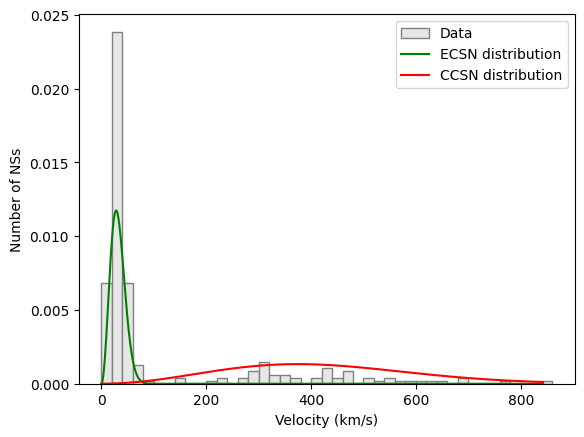

In [229]:
a1_true = 20.0
a2_true = 265.0
f_true = 0.4
N = 500
v = make_velocity_sample(a1_true, a2_true, f_true, N)

v_step = 20.0
v_bins = np.arange(0.0, max(v)+v_step, v_step)
v_plot = np.linspace(0.0, max(v), 1000)
normalization = 1 # N * v_step
plt.figure()
plt.hist(v, bins=v_bins, color="0.9", ec="0.5", label="Data", density=True)
plt.plot(v_plot, normalization * f_true * st.maxwell(scale=a1_true).pdf(v_plot), "g-", label="ECSN distribution")
plt.plot(v_plot, normalization * (1.0 - f_true) * st.maxwell(scale=a2_true).pdf(v_plot), "r-", label="CCSN distribution")
plt.xlabel("Velocity (km/s)")
plt.ylabel("Number of NSs")
plt.legend(loc="upper right")
plt.show()

In [230]:
def ln_prior_a1(a1):
    return -np.inf if a1 <= 0 else 0.0

def ln_prior_a2(a2):
    return -np.inf if a2 <= 0 else 0.0

def ln_prior_f(f):
    return -np.inf if f < 0 or f > 1 else 0.0

def ln_prior(a1, a2, f):
#     if a1 > a2:
#         return -np.inf
    return ln_prior_a1(a1) + ln_prior_a2(a2) + ln_prior_f(f)

def datum_ln_likelihood(v, a1, a2, f):
    return np.log(f * st.maxwell.pdf(v, scale=a1) + (1.0 - f) * st.maxwell.pdf(v, scale=a2))

def ln_likelihood(velocities, a1, a2, f):
    return sum(datum_ln_likelihood(velocities, a1, a2, f))

def ln_posterior(a1, a2, f, velocities):
    return ln_prior(a1, a2, f) + ln_likelihood(velocities, a1, a2, f)

# Manual MCMC

# Using `emcee`

In [231]:
n_walkers = 100
n_dim = 3
n_steps = 400

# set the parameter
a1_positions = np.random.uniform(0.0, 200.0, size=n_walkers)
a2_positions = np.random.uniform(0.0, 200.0, size=n_walkers)
f_positions = np.random.uniform(0.0, 1.0, size=n_walkers)

# take the initial values for each parameter and put them in columns of a 2D array
positions = np.array([a1_positions, a2_positions, f_positions]).T

def ln_posterior_mcmc(parameters):
    a1, a2, f = parameters
    result = ln_posterior(a1, a2, f, v)
    return -np.inf if np.isnan(result) else result

sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=ln_posterior_mcmc)

In [232]:
result = sampler.run_mcmc(positions, nsteps=n_steps, progress="notebook")

  0%|          | 0/400 [00:00<?, ?it/s]

/tmp/ipykernel_292856/1029866870.py:16: RuntimeWarning: invalid value encountered in log
  return np.log(f * st.maxwell.pdf(v, scale=a1) + (1.0 - f) * st.maxwell.pdf(v, scale=a2))
/tmp/ipykernel_292856/1029866870.py:16: RuntimeWarning: divide by zero encountered in log
  return np.log(f * st.maxwell.pdf(v, scale=a1) + (1.0 - f) * st.maxwell.pdf(v, scale=a2))


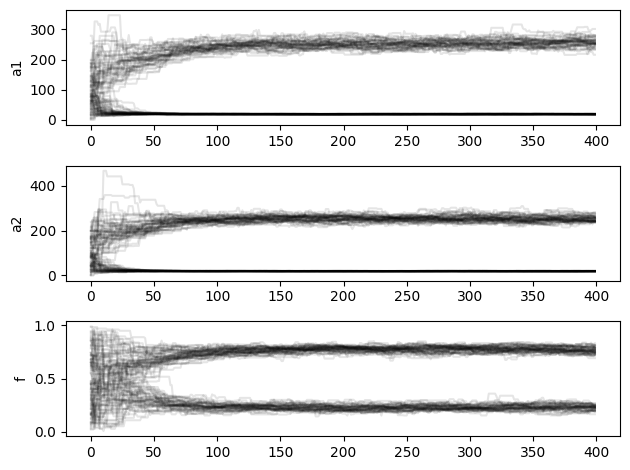

In [233]:
plt.figure()

labels = ["a1", "a2", "f"]

for param_i, label_i in zip(range(n_dim), labels):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(label_i)
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

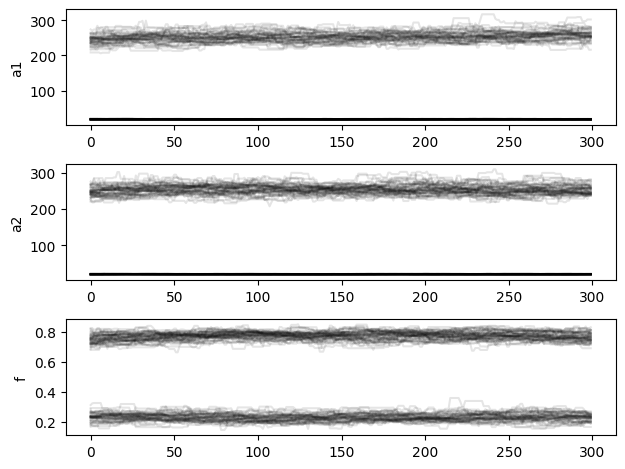

In [234]:
n_burnin = 100

for param_i, label_i in zip(range(n_dim), labels):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(label_i)
    for j in range(n_walkers):
        chain = sampler.chain[j, n_burnin:, param_i]
        plt.plot(chain, "k-", alpha=0.1)
plt.tight_layout()
plt.show()

Converged chain shape     : (100, 300, 3)
Converged flatchain shape : (30000, 3)


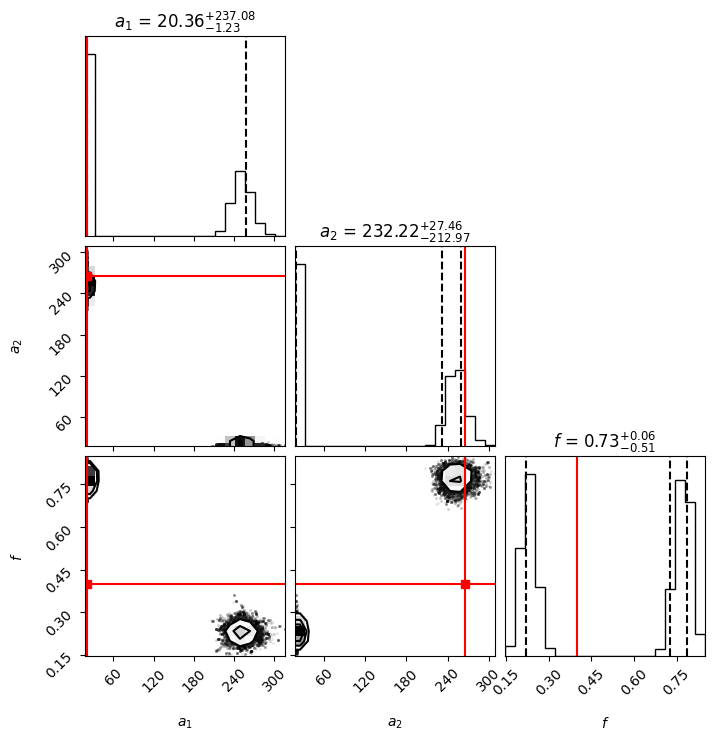

In [235]:
converged_chain = sampler.chain[:, n_burnin:, :]
print("Converged chain shape     :", converged_chain.shape)

flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
print("Converged flatchain shape :", flat_converged_chain.shape)

fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a1_true, a2_true, f_true],
                    truth_color="r",
                    labels=[r"$a_1$", r"$a_2$", r"$f$"],
                    show_titles=True, 
                    # range=[0.95]*3,
                   )

* You can somehow see a slight preference of using only one component (the peaks at 0 and 1 in the f distribution).
* Also, when the f is 0 or 1, you see that a2 and a1 are better constrained respectively (you don't care of the parameter of a component that doesn't participate at all in the likelihood).
* when f is not extreme, a1 and a2 take more or less the same value... to create an up-scaled version of the original distribution!

In [209]:
# simulate a sample
a1_true = 265.0
a2_true = 265.0
f_true = 0.4
N = 500
v = make_velocity_sample(a1_true, a2_true, f_true, N, verbose=False)
# MCMC process
n_walkers = 200
n_dim = 3
n_steps = 400
a1_positions = np.random.uniform(0.0, 400.0, size=n_walkers)
a2_positions = np.random.uniform(0.0, 400.0, size=n_walkers)
f_positions = np.random.uniform(0.0, 1.0, size=n_walkers)
positions = np.array([a1_positions, a2_positions, f_positions]).T

def ln_posterior_mcmc(parameters):
    a1, a2, f = parameters
    if a1 < 0.0 or a2 < 0.0 or f < 0 or f > 1:
        return -np.inf
#     if a1 > a2:
#         return -np.inf
    result = sum(np.log(f * st.maxwell.pdf(v, scale=a1) + (1.0 - f) * st.maxwell.pdf(v, scale=a2)))
    return -np.inf if np.isnan(result) else result


sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_dim, log_prob_fn=ln_posterior_mcmc)
result = sampler.run_mcmc(positions, nsteps=n_steps, progress="notebook")

/tmp/ipykernel_292856/3041100940.py:22: RuntimeWarning: divide by zero encountered in log
  result = sum(np.log(f * st.maxwell.pdf(v, scale=a1) + (1.0 - f) * st.maxwell.pdf(v, scale=a2)))


  0%|          | 0/400 [00:00<?, ?it/s]

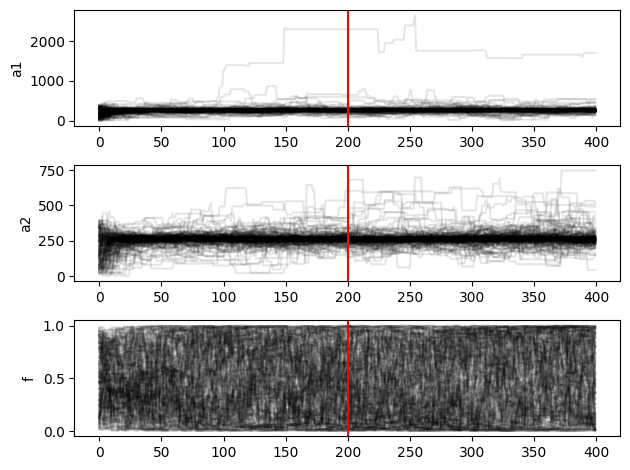

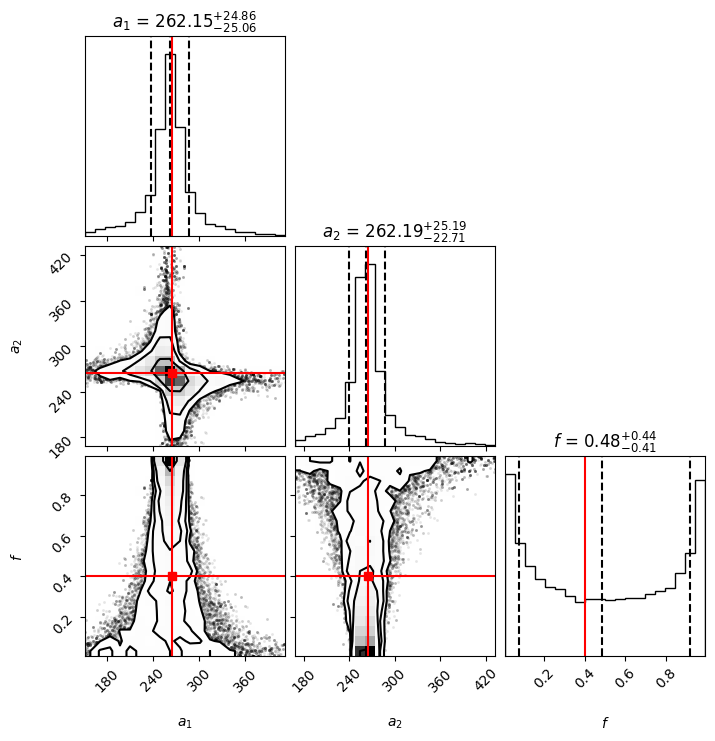

In [210]:
n_burnin = 200

plt.figure()
for param_i, label_i in zip(range(n_dim), labels):
    plt.subplot(n_dim, 1, 1+param_i)
    plt.ylabel(label_i)
    for j in range(n_walkers):
        chain = sampler.chain[j, :, param_i]
        plt.plot(chain, "k-", alpha=0.1)
    plt.axvline(n_burnin, color="r")
plt.tight_layout()
plt.show()

converged_chain = sampler.chain[:, n_burnin:, :]
flat_converged_chain = converged_chain.reshape(converged_chain.shape[0] * converged_chain.shape[1], -1)
fig = corner.corner(flat_converged_chain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[a1_true, a2_true, f_true],
                    truth_color="r",
                    labels=[r"$a_1$", r"$a_2$", r"$f$"],
                    show_titles=True,
                    range=[0.95]*3,
                   )